In [1]:
from lenskit.als import BiasedMFScorer
from lenskit.batch import recommend
from lenskit.data import ItemListCollection, UserIDKey, load_movielens
from lenskit.knn import ItemKNNScorer
from lenskit.metrics import NDCG, RBP, RecipRank, RunAnalysis
from lenskit.pipeline import topn_pipeline
from lenskit.splitting import SampleFrac, crossfold_users

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from pyprojroot.here import here
from pathlib import Path


In [4]:

ml100k = load_movielens(Path("C:/SCHOOL/Spring2024/HPML/Project/100k/1monoine/data/ml-1m.zip"))
ml100k.interaction_table(format="pandas", original_ids=True).head()

,user_id,item_id,rating,timestamp
0,1,1,5.0,2001-01-06 23:37:48
1,1,48,5.0,2001-01-06 23:39:11
2,1,150,5.0,2000-12-31 22:29:37
3,1,260,4.0,2000-12-31 22:12:40
4,1,527,5.0,2001-01-06 23:36:35


In [5]:
model_ii = ItemKNNScorer(k=20)
model_als = BiasedMFScorer(features=50)

In [6]:
pipe_ii = topn_pipeline(model_ii)
pipe_als = topn_pipeline(model_als)

In [7]:
# test data is organized by user
all_test = ItemListCollection(UserIDKey)
# recommendations will be organized by model and user ID
all_recs = ItemListCollection(["model", "user_id"])

for split in crossfold_users(ml100k, 5, SampleFrac(0.2)):
    # collect the test data
    all_test.add_from(split.test)

    # train the pipeline, cloning first so a fresh pipeline for each split
    fit_als = pipe_als.clone()
    fit_als.train(split.train)
    # generate recs
    als_recs = recommend(fit_als, split.test.keys(), 100)
    all_recs.add_from(als_recs, model="ALS")

    # do the same for item-item
    fit_ii = pipe_ii.clone()
    fit_ii.train(split.train)
    ii_recs = recommend(fit_ii, split.test.keys(), 100)
    all_recs.add_from(ii_recs, model="II")

C:\Users\arshs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lenskit\als\_explicit.py:58: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  rmat = rmat.to_sparse_csr()


In [8]:
ran = RunAnalysis()
ran.add_metric(NDCG())
ran.add_metric(RBP())
ran.add_metric(RecipRank())
results = ran.measure(all_recs, all_test)

In [9]:
results.list_metrics().groupby("model").mean()


,NDCG,RBP,RecipRank
model,,,
ALS,0.091661,0.065982,0.179740
II,0.068557,0.037794,0.090731


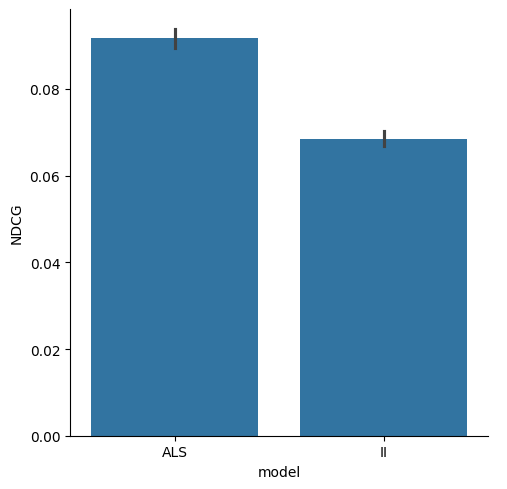

In [10]:
sns.catplot(results.list_metrics().reset_index(), x="model", y="NDCG", kind="bar")
plt.show()

AttributeError: 'ListILC' object has no attribute 'to_pandas'